# Machine Learning Pipeline   
### *An Implementation of [DonorsChoose Project](https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data)*  

*Yeol Ye   
University of Chicago  
ziyuye@uchicago.edu*

## Phase 1: Data Preparation

In [1]:
import os
import sys
import warnings
sys.path.append('../code/')
warnings.filterwarnings('ignore')

In [2]:
import prep
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
from scipy.stats import norm, lognorm
import statsmodels.api as sm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta

In [3]:
data_file = 'projects_2012_2013.csv'
df = pd.read_csv('../data/source/projects_2012_2013.csv')
target_name = 'fully_funded'
num_list = ['school_latitude', 'school_longitude',
            'total_price_including_optional_support', 'students_reached']

In [4]:
df['date_posted'] = pd.to_datetime(df['date_posted'])
df['datefullyfunded'] = pd.to_datetime(df['datefullyfunded'])
df['fully_funded'] = (df['datefullyfunded'] - df['date_posted']) > timedelta(days=60)
df_cleaned = df.astype({'school_latitude': np.float, 'school_longitude': np.float, 'fully_funded': np.float,
                        'total_price_including_optional_support': np.float, 'students_reached': np.float})

target, features = prep.target_features_split(target_name, df)
cat, numeric = prep._num_cat_split(features, num_list)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124976 entries, 0 to 124975
Data columns (total 27 columns):
projectid                                 124976 non-null object
teacher_acctid                            124976 non-null object
schoolid                                  124976 non-null object
school_ncesid                             115743 non-null float64
school_latitude                           124976 non-null float64
school_longitude                          124976 non-null float64
school_city                               124976 non-null object
school_state                              124976 non-null object
school_metro                              109752 non-null object
school_district                           124804 non-null object
school_county                             124976 non-null object
school_charter                            124976 non-null object
school_magnet                             124976 non-null object
teacher_prefix                           

## Phase 2: Data Exploration

In [6]:
numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124976 entries, 0 to 124975
Data columns (total 4 columns):
school_latitude                           124976 non-null float64
school_longitude                          124976 non-null float64
total_price_including_optional_support    124976 non-null float64
students_reached                          124917 non-null float64
dtypes: float64(4)
memory usage: 3.8 MB


In [7]:
__df = df_cleaned[:]
__df = __df.drop('date_posted', axis=1)
__df = __df.drop('datefullyfunded', axis=1)

In [8]:
import seaborn as sns
import matplotlib
sns.set(style='whitegrid')
%matplotlib inline

import explore

%config InlineBackend.figure_format = 'retina' 

### 2.1 Check the Distribution for the Target

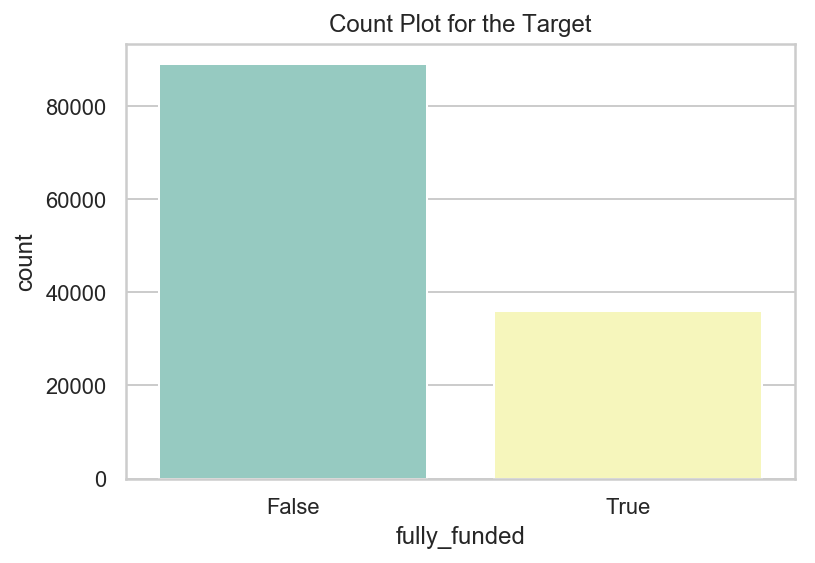

In [9]:
explore.count_plot(target_name, target, 'Count Plot for the Target')

### 2.2 Check the Distribution for Selected Categorical Columns of Features

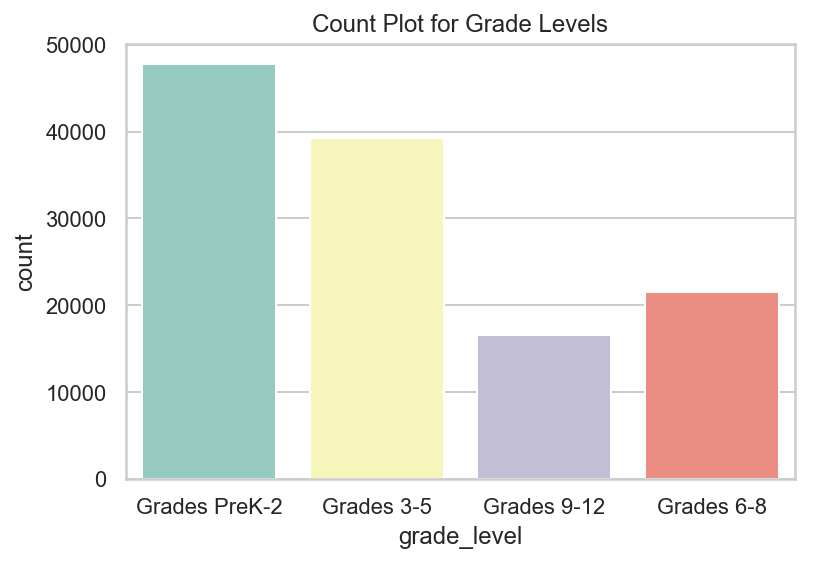

In [10]:
explore.count_plot('grade_level', features, 'Count Plot for Grade Levels')

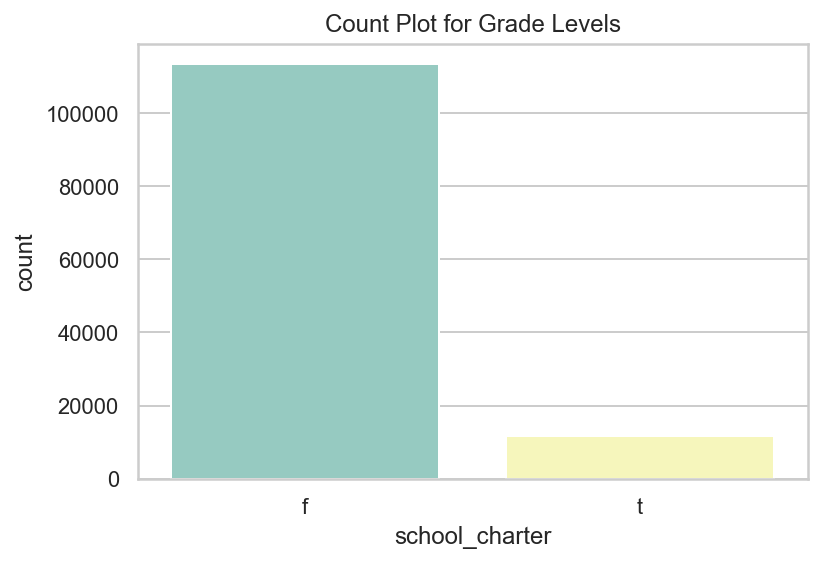

In [11]:
explore.count_plot('school_charter', features, 'Count Plot for Grade Levels')

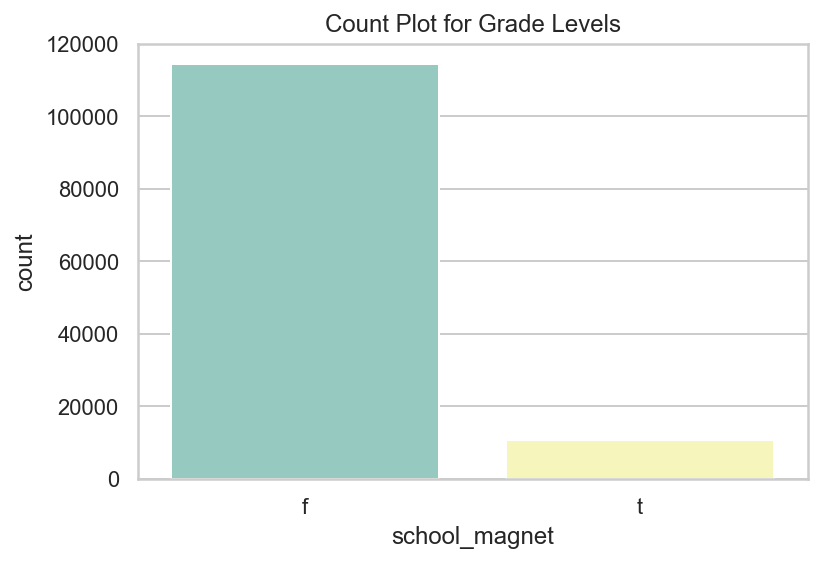

In [12]:
explore.count_plot('school_magnet', features, 'Count Plot for Grade Levels')

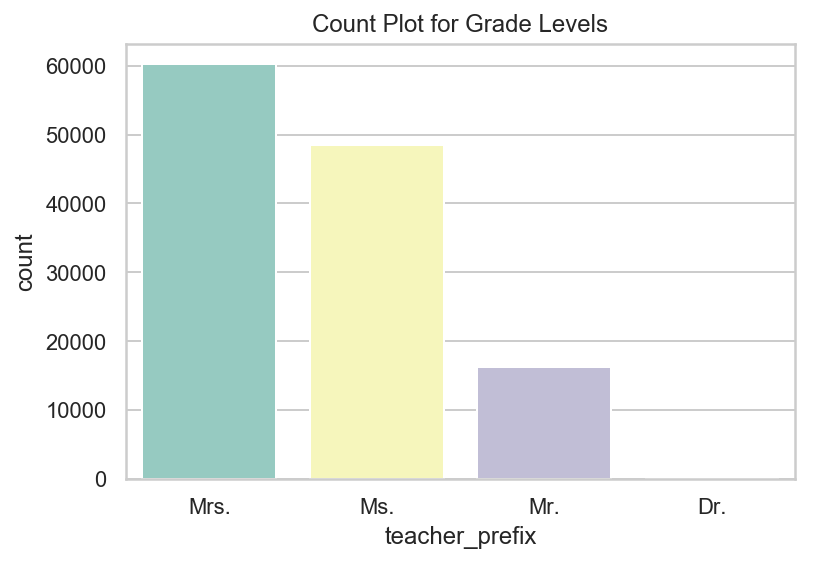

In [13]:
explore.count_plot('teacher_prefix', features, 'Count Plot for Grade Levels')

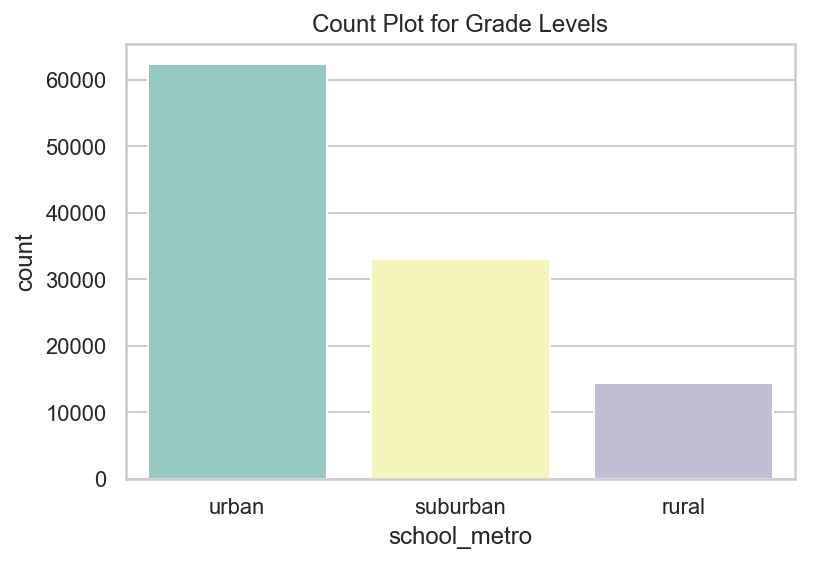

In [14]:
explore.count_plot('school_metro', features, 'Count Plot for Grade Levels')

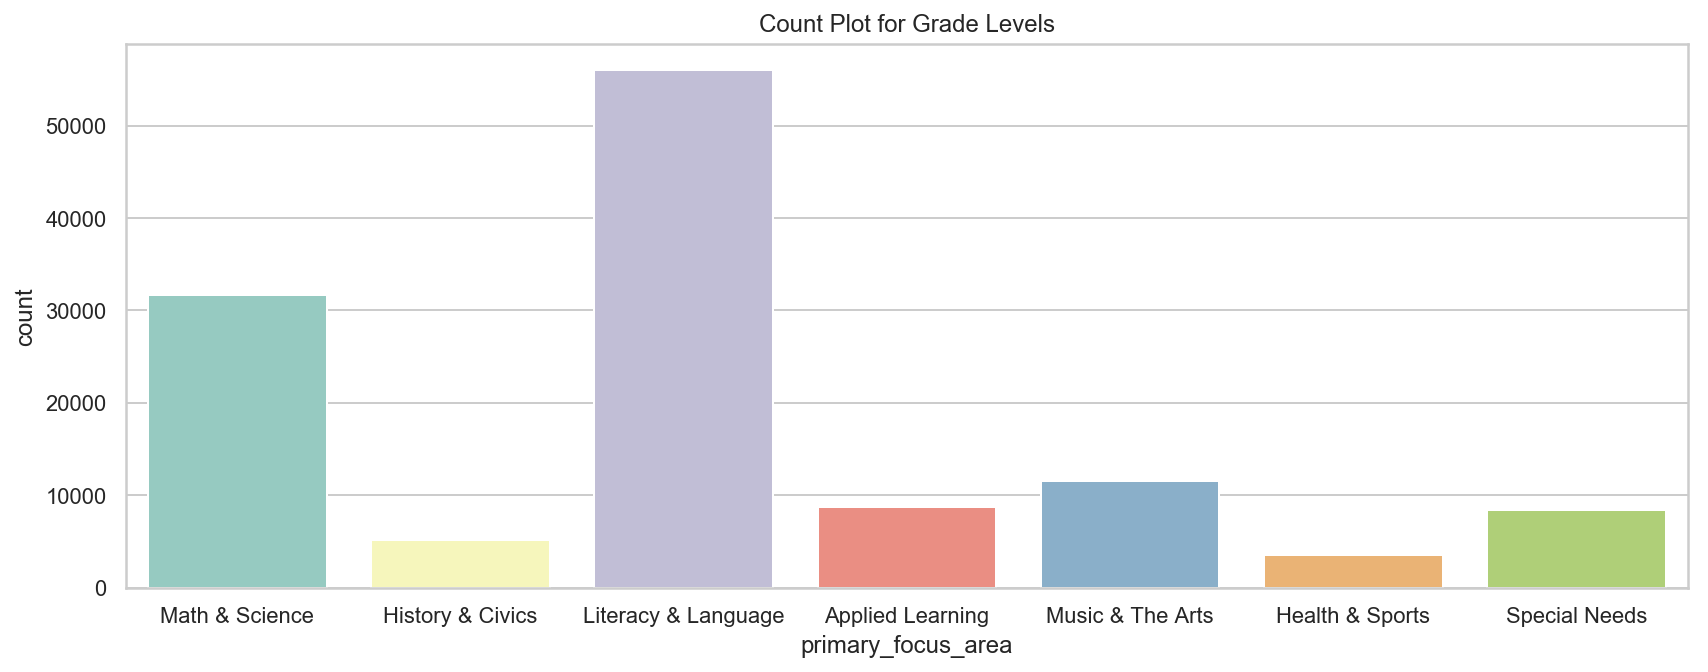

In [15]:
plt.rcParams['figure.figsize'] = (14.0, 5.0)
explore.count_plot('primary_focus_area', features, 'Count Plot for Grade Levels')

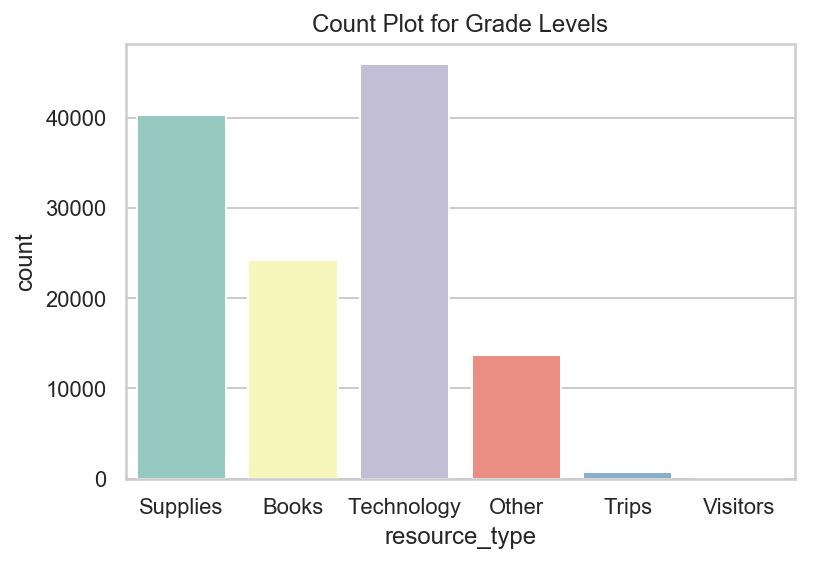

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
explore.count_plot('resource_type', features, 'Count Plot for Grade Levels')

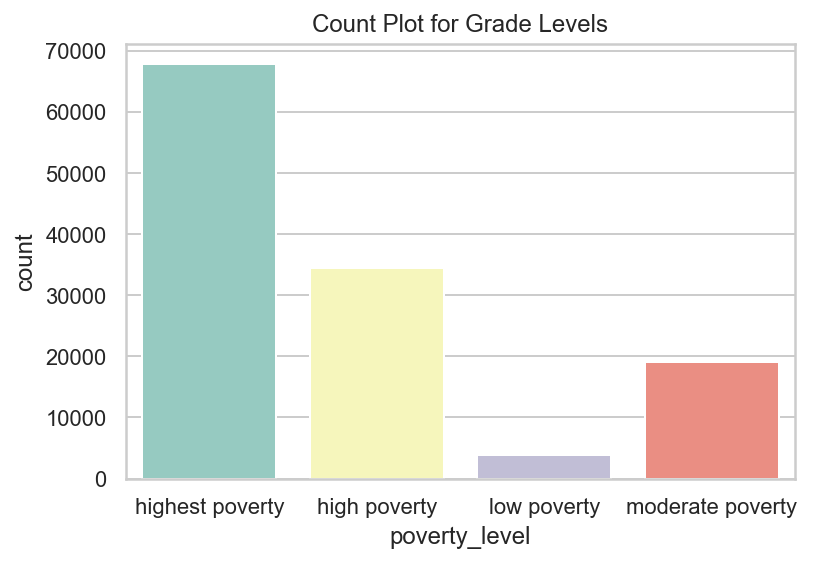

In [17]:
explore.count_plot('poverty_level', features, 'Count Plot for Grade Levels')

### 2.3 Check the Distribution and Outliers for Numeric Data

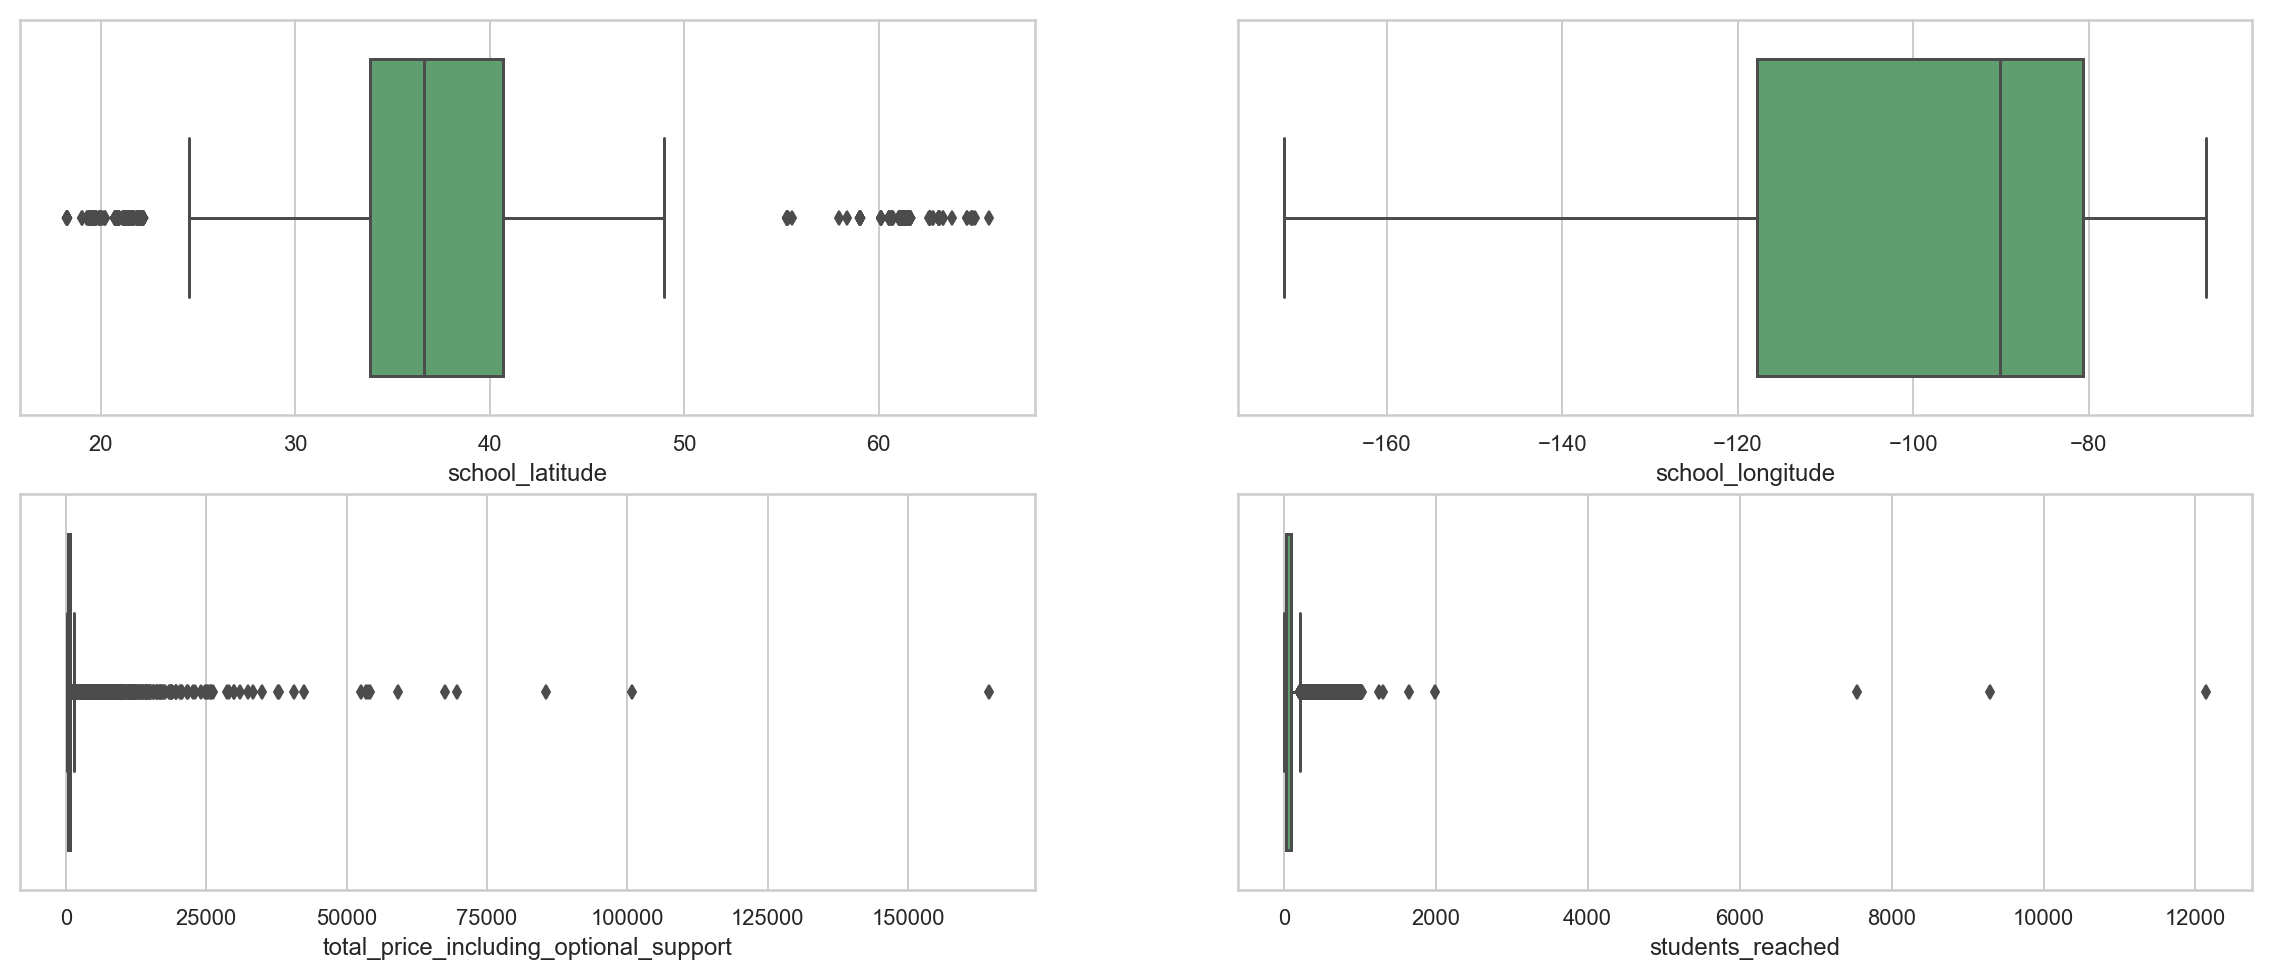

In [18]:
explore.box_plot(numeric)

> Giving the plot above, we could find that there exists some outliers in the data, and it would be useful to filter out all these outliers and see the distribution of the data. The following function for distribution used the data between the 0.05 quantile and 0.95 quantile.   

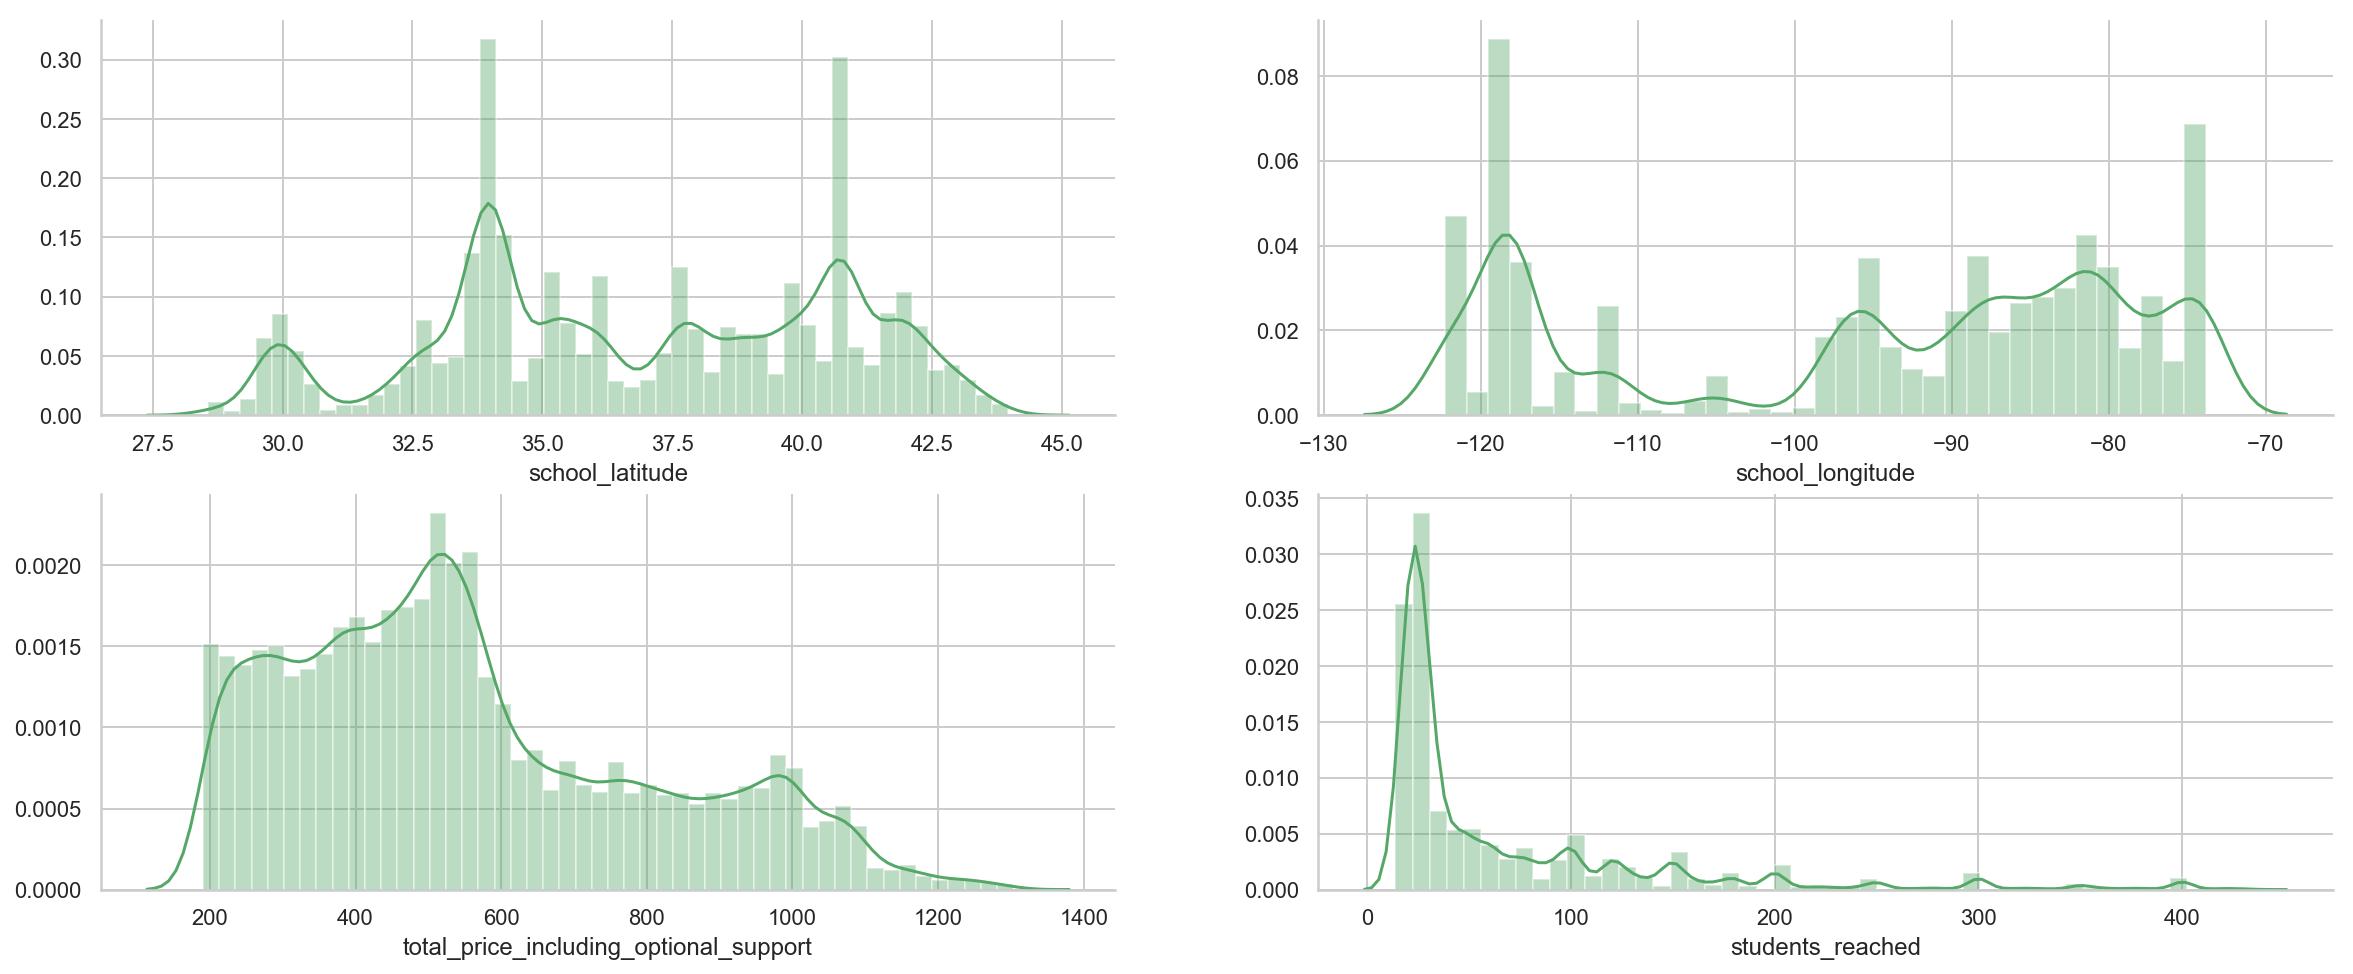

In [19]:
explore.dist_plot(numeric)

### 2.4 Check the Correlation Matrix of Numeric Columns

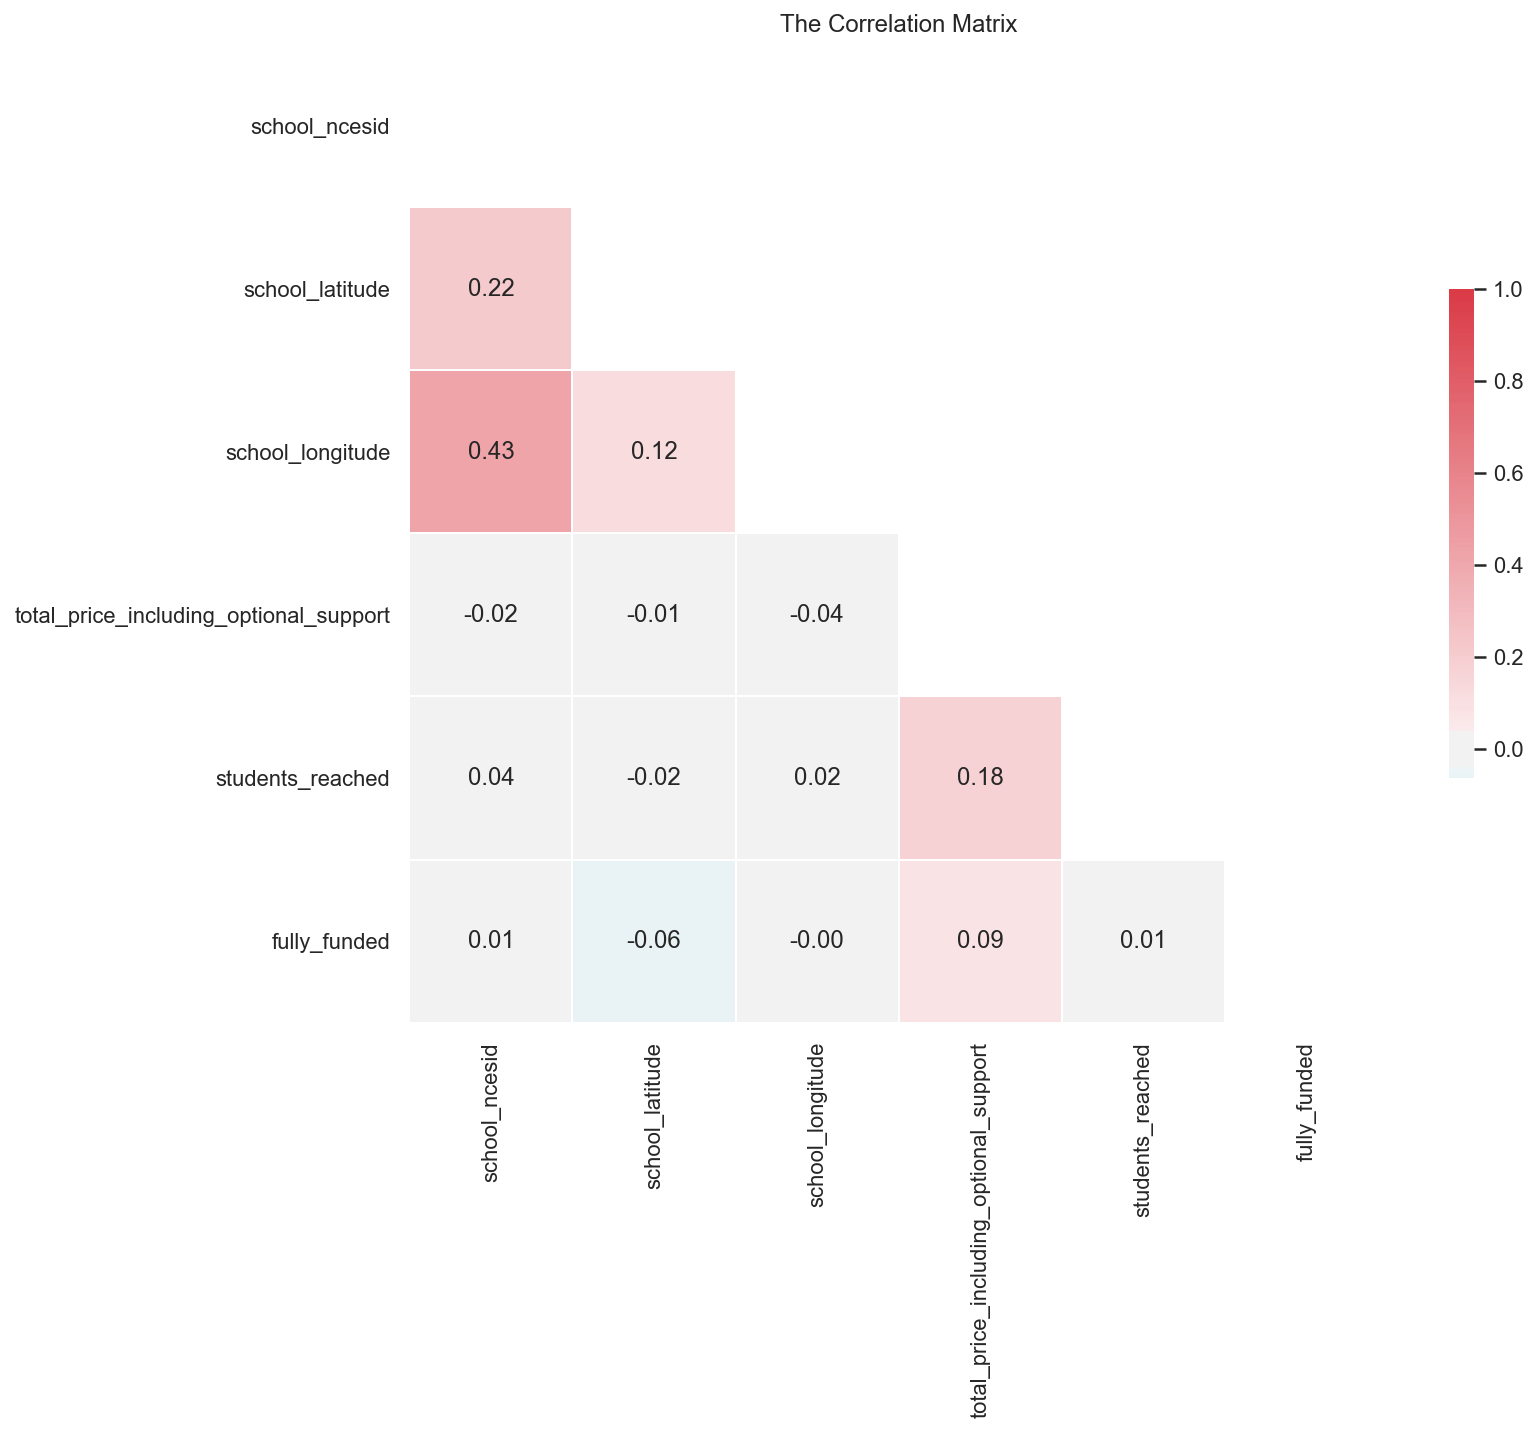

In [20]:
explore.corr_plot(df)

### 2.5 Drop Some Features with High Correlations

> In this sample, we do not find any feature has high correlation with one another, thus we do not need to drop features this time. : )

### 2.6 Draw Pair Plot for Numeric Features and Check the Possibility for a Machine Learning Method

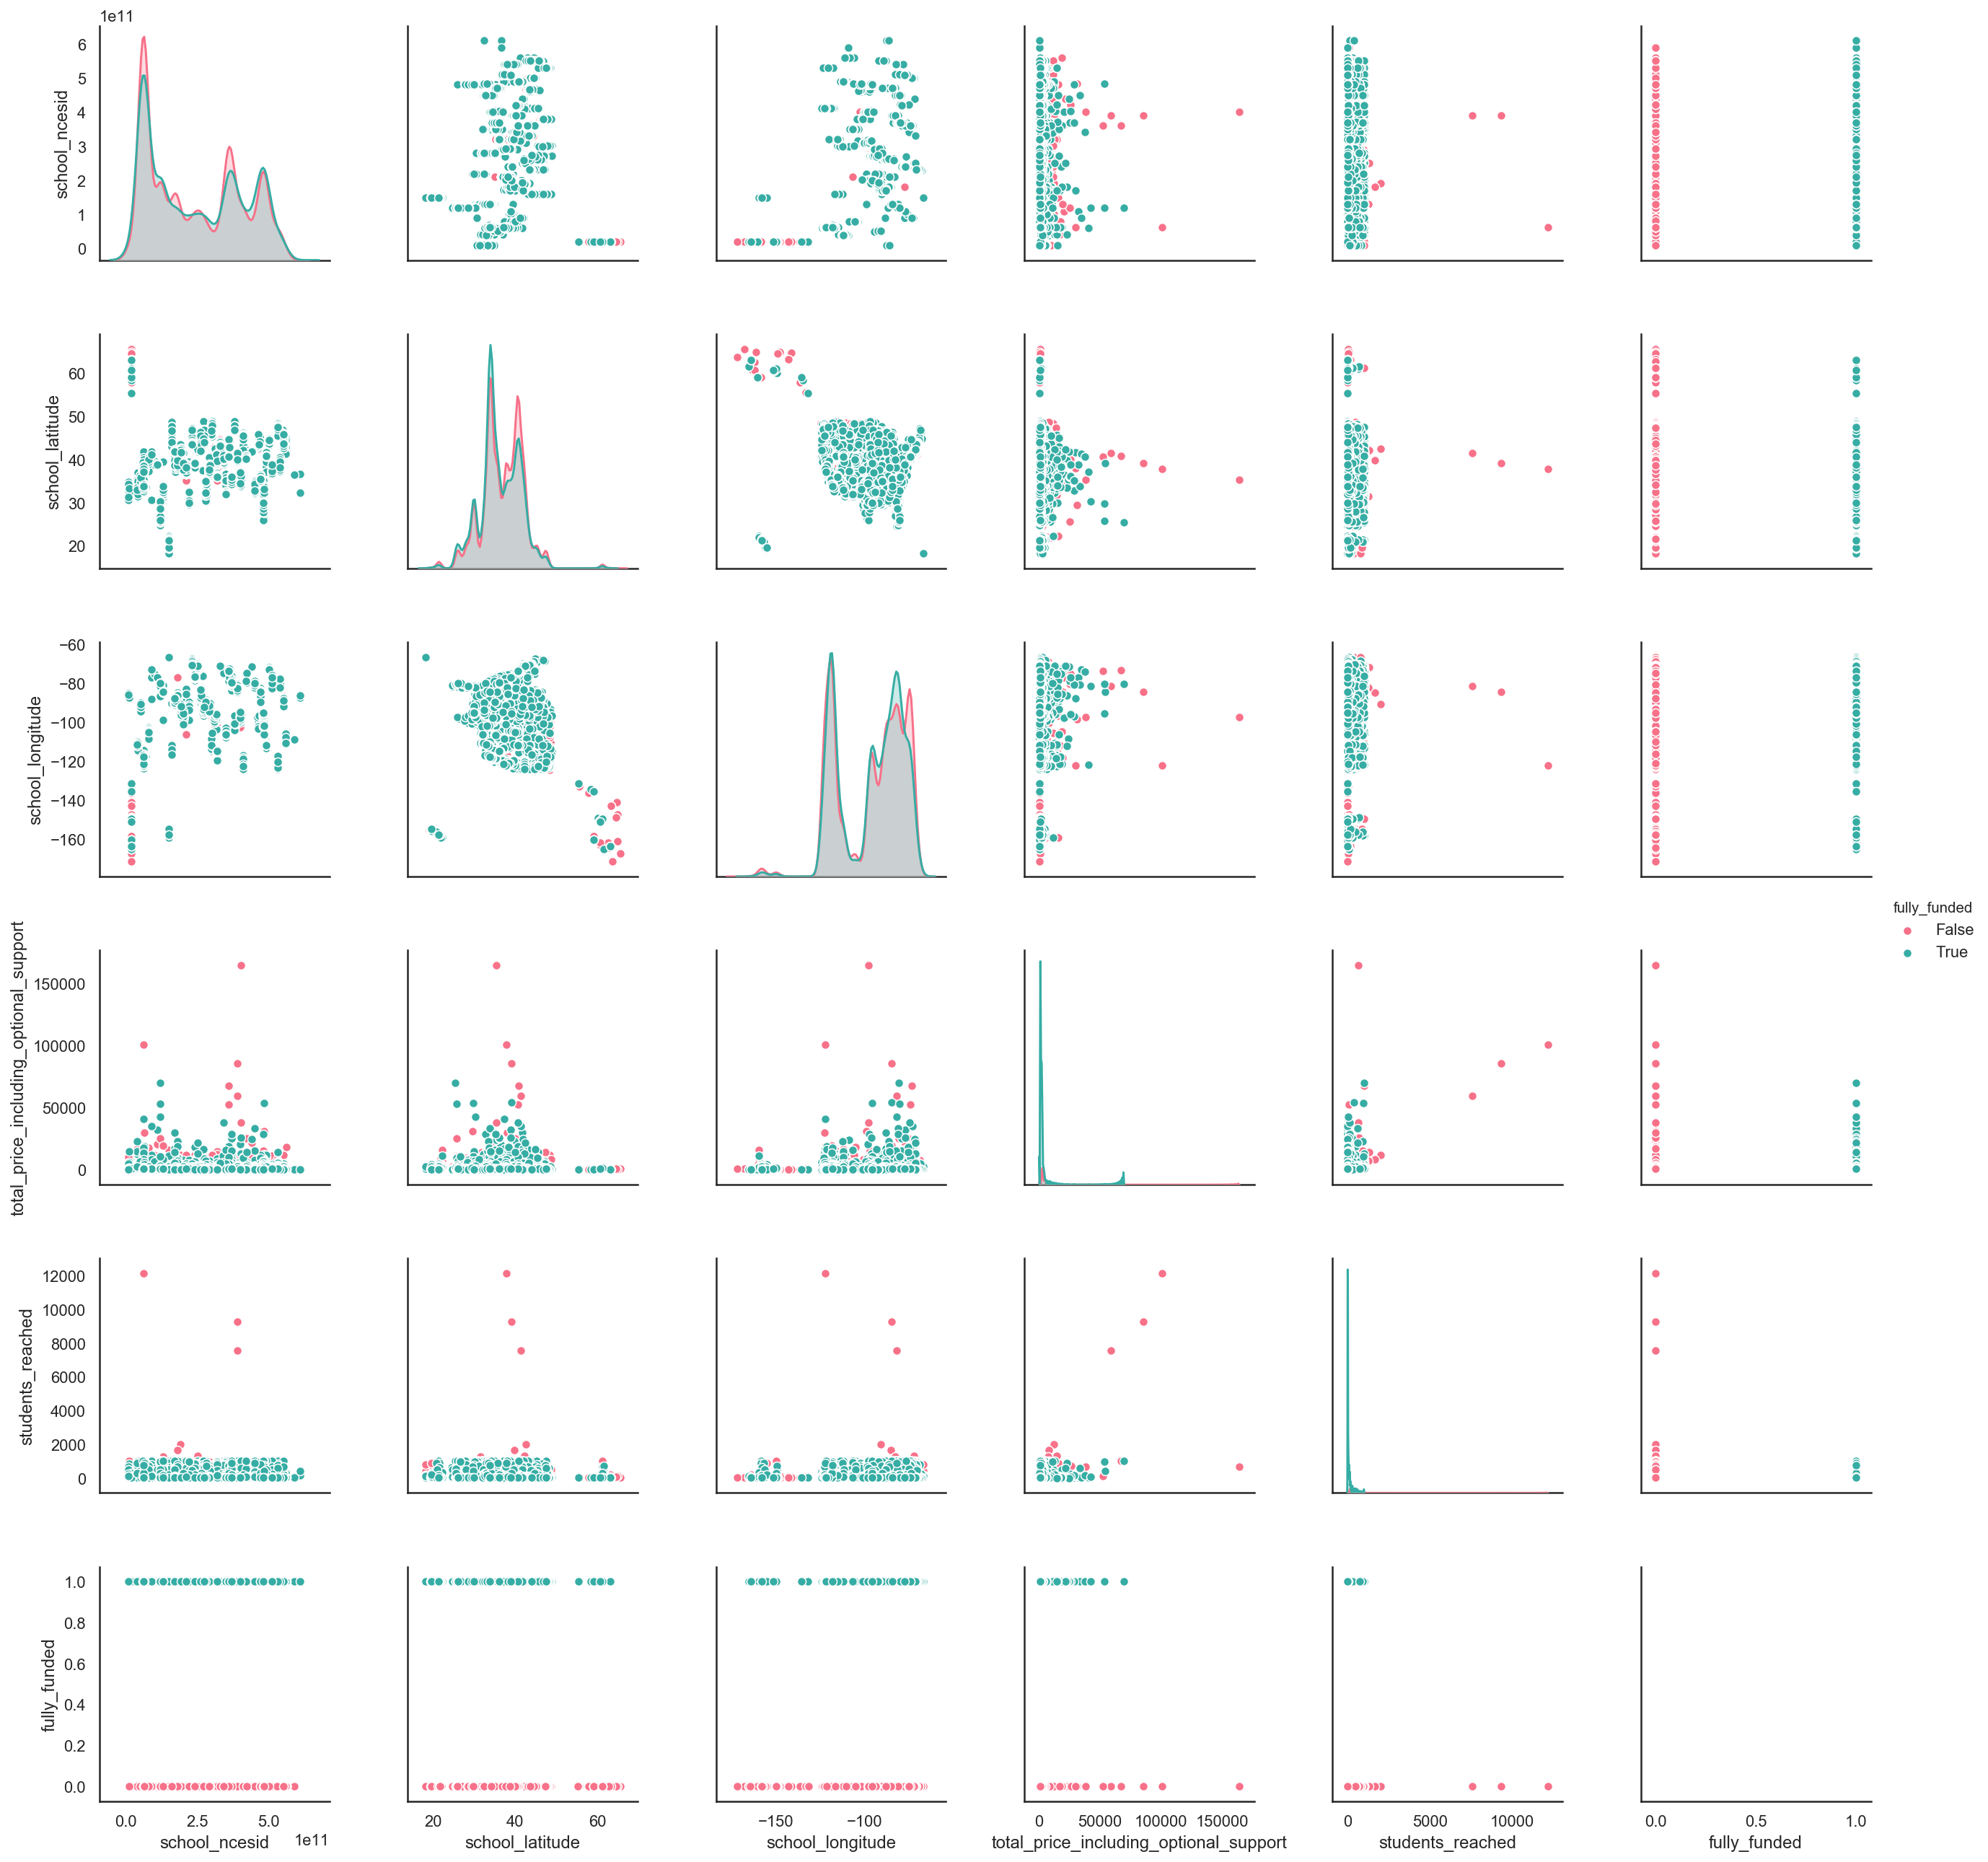

In [21]:
temp = list(features.columns)
temp.append(target_name)
sorted_data = df[temp]
sns.pairplot(sorted_data, height=3, hue=target_name, palette='husl')

> From the plots, we can see that the two classes of the target value seem to be somewhat separated by some of the features, e.g. `Total Price Including Optional Support`.This implies the potential feasibility to use a machine learning algorithm to separate the data by label.   
   
> Note that it is also possible to transform *category data* into numeric (i.e dummy) data and generate the pair plot. This step is skipped here due to limited space for images. The code part of this project provides such a method.

## Phase 3: Feature Engineering

### 3.0 Temporal Train Test Split

In [22]:
import feature

In [23]:
list_to_drop = ['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid']
df_cleaned = df.drop(list_to_drop, axis=1)

In [24]:
batches = feature.temporal_split(df_cleaned, 'date_posted', "5M", "60D")

Using a test length of '5M', with a '60D' gap between training and test sets, and at the end of the data set observations of the last '60D' cannot be used for either training or testing.
Print the start and end date for each of the 3 pairs of training and test sets to verify the split works.

<TRAINING-TEST PAIR 0>
<TRAINING SET TIME RANGE> 2012-01-01 - 2012-05-31
<TEST SET TIME RANGE> 2012-07-31 - 2012-12-29



<TRAINING-TEST PAIR 1>
<TRAINING SET TIME RANGE> 2012-01-01 - 2012-10-30
<TEST SET TIME RANGE> 2012-12-30 - 2013-05-30



<TRAINING-TEST PAIR 2>
<TRAINING SET TIME RANGE> 2012-01-01 - 2013-03-31
<TEST SET TIME RANGE> 2013-05-31 - 2013-10-29





### 3.1 Cut Outliers for Certain Features

> By inspecting the distribution of numeric features, I decide not to cut outliers, as they are very few and represent meaningful information. Although this step is skipped here, you can find relavant function in the code section of the project.

### 3.2 Discretize Continuous Features

> By inspecting the content of numeric features, I decide that they should be considered as continuous variable rather than discrete variable, thus this step is skipped here. Although this step is skipped here, you can find relavant function in the code section of the project.

### 3.3 Fill in Missing Values

In [25]:
df_cleaned.isnull().sum()

school_latitude                               0
school_longitude                              0
school_city                                   0
school_state                                  0
school_metro                              15224
school_district                             172
school_county                                 0
school_charter                                0
school_magnet                                 0
teacher_prefix                                0
primary_focus_subject                        15
primary_focus_area                           15
secondary_focus_subject                   40556
secondary_focus_area                      40556
resource_type                                17
poverty_level                                 0
grade_level                                   3
total_price_including_optional_support        0
students_reached                             59
eligible_double_your_impact_match             0
date_posted                             

In [26]:
TO_FILL_CON = {'students_reached'}

TO_FILL_OBJ = {'school_metro': None,
               'school_district': "MISC",
               'primary_focus_subject': "Other",
               'primary_focus_area': "Other",
               'secondary_focus_subject': "MISC",
               'secondary_focus_area': "MISC",
               'resource_type': None}

In [27]:
for i, (train, test) in enumerate(batches):
    print("#" + "-" * 100 + "#")
    print("<BATCH %s>" % i)
    train, test = feature.con_fill_na(train, TO_FILL_CON), feature.con_fill_na(test, TO_FILL_CON)
    batches[i] = feature.str_fill_na(train, TO_FILL_OBJ), feature.str_fill_na(test, TO_FILL_OBJ)
    print("#" + "-" * 100 + "#\n\n")

#----------------------------------------------------------------------------------------------------#
<BATCH 0>


Start to impute missing values continuous variables:
	Missing values in 'students_reached' imputed with column median 30.000.


Start to impute missing values continuous variables:
	Missing values in 'students_reached' imputed with column median 33.000.


Start to fill in missing values:
	Filled missing values in 'school_metro' with 'urban'.
	Filled missing values in 'school_district' with 'MISC'.
	Filled missing values in 'primary_focus_subject' with 'Other'.
	Filled missing values in 'primary_focus_area' with 'Other'.
	Filled missing values in 'secondary_focus_subject' with 'MISC'.
	Filled missing values in 'secondary_focus_area' with 'MISC'.
	Filled missing values in 'resource_type' with 'Technology'.


Start to fill in missing values:
	Filled missing values in 'school_metro' with 'urban'.
	Filled missing values in 'school_district' with 'MISC'.
	Filled missing values i

### 3.3 Transform Categorical Features to Dummies

First combine levels that are not frequent (less than 5%) of a list of categorical variables.

In [28]:
TO_COMBINE = {'teacher_prefix': {"Mr.": ["Dr."]},
              'school_city': {"MISC": None},
              'school_state': {"MISC": None},
              'school_district': {"MISC": None},
              'school_county': {"MISC": None},
              'primary_focus_subject': {"Other": None},
              'primary_focus_area': {"Other": None},
              'secondary_focus_subject': {"Other": None},
              'secondary_focus_area': {"Other": None},
              'resource_type': {"Other": None}}

TO_BINARIES = {'school_charter': 'auto',
               'school_magnet': 'auto',
               'eligible_double_your_impact_match': 'auto'}

TO_ONE_HOT = ['school_city', 'school_state', 'school_district',
              'school_county', 'school_metro', 'teacher_prefix',
              'primary_focus_subject', 'primary_focus_area',
              'secondary_focus_subject', 'secondary_focus_area',
              'resource_type', 'poverty_level', 'grade_level']

In [29]:
for i, (train, test) in enumerate(batches):
    print("#" + "-" * 100 + "#")
    print("<BATCH %s>" % i)
    train, test = feature.to_combine(train, TO_COMBINE), feature.to_combine(test, TO_COMBINE)
    train, test = feature.to_binary(train, TO_BINARIES), feature.to_binary(test, TO_BINARIES)
    train, test = feature.one_hot_encoding(train, TO_ONE_HOT), feature.one_hot_encoding(test, TO_ONE_HOT)
    batches[i] = train, feature.compare_train_test(test, train.columns)
    print("#" + "-" * 100 + "#\n\n")

#----------------------------------------------------------------------------------------------------#
<BATCH 0>


Start to combine unnecessary levels of multinomials.
	Combinations of levels on 'teacher_prefix'.
	Combinations of levels on 'school_city'.
	Combinations of levels on 'school_state'.
	Combinations of levels on 'school_district'.
	Combinations of levels on 'school_county'.
	Combinations of levels on 'primary_focus_subject'.
	Combinations of levels on 'primary_focus_area'.
	Combinations of levels on 'secondary_focus_subject'.
	Combinations of levels on 'secondary_focus_area'.
	Combinations of levels on 'resource_type'.


Start to combine unnecessary levels of multinomials.
	Combinations of levels on 'teacher_prefix'.
	Combinations of levels on 'school_city'.
	Combinations of levels on 'school_state'.
	Combinations of levels on 'school_district'.
	Combinations of levels on 'school_county'.
	Combinations of levels on 'primary_focus_subject'.
	Combinations of levels on 'primary

In [30]:
for train, test in batches:
    print("#" + "-" * 100 + "#")
    print("<BATCH %s>" % i)
    print("Columns with missing values in training data: ", list(train.columns[train.isnull().any()]))
    print("Columns with missing values in test data: ", list(test.columns[test.isnull().any()]))
    print("#" + "-" * 100 + "#\n\n")

#----------------------------------------------------------------------------------------------------#
<BATCH 2>
Columns with missing values in training data:  []
Columns with missing values in test data:  []
#----------------------------------------------------------------------------------------------------#


#----------------------------------------------------------------------------------------------------#
<BATCH 2>
Columns with missing values in training data:  []
Columns with missing values in test data:  []
#----------------------------------------------------------------------------------------------------#


#----------------------------------------------------------------------------------------------------#
<BATCH 2>
Columns with missing values in training data:  []
Columns with missing values in test data:  []
#----------------------------------------------------------------------------------------------------#




No value missing, we are good to split features and target. 

### 3.4 Feature-Target Split

In [31]:
TARGET = 'fully_funded'
TO_DROP = ['date_posted', 'datefullyfunded', 'fully_funded']

In [32]:
for i, (train, test) in enumerate(batches):
    print("#" + "-" * 100 + "#")
    print("<BATCH %s>" % i)
    y_train, y_test = train[TARGET], test[TARGET]
    X_train, X_test = train.drop(TO_DROP, axis=1), test.drop(TO_DROP, axis=1)
    print('Finished split training and test features and target')
    batches[i] = X_train, y_train, X_test, y_test
    print("#" + "-" * 100 + "#\n\n")

#----------------------------------------------------------------------------------------------------#
<BATCH 0>
Finished split training and test features and target
#----------------------------------------------------------------------------------------------------#


#----------------------------------------------------------------------------------------------------#
<BATCH 1>
Finished split training and test features and target
#----------------------------------------------------------------------------------------------------#


#----------------------------------------------------------------------------------------------------#
<BATCH 2>
Finished split training and test features and target
#----------------------------------------------------------------------------------------------------#




### 3.5 Scale Data

Scale data with standard scaler. Fit on the training set, and transform both training set and test set.

In [33]:
INPUT_DIR = "../data/scalers/"

In [35]:
for i, (X_train, y_train, X_test, y_test) in enumerate(batches):
    print("#" + "-" * 100 + "#")
    print("<BATCH %s>" % i)
    X_train = feature.scale(X_train, False, i, INPUT_DIR)
    X_test = feature.scale(X_test, True, i, INPUT_DIR)
    batches[i] = X_train, y_train, X_test, y_test
    print("#" + "-" * 100 + "#\n\n")

#----------------------------------------------------------------------------------------------------#
<BATCH 0>


<Training data preprocessing> Fitted scaler dumped to 'fitted_scaler.pkl' under directory '../data/scalers/Batch 0/'.
Finished scaling the feature matrix.


<BATCH 0: Test data preprocessing> Pre-fitted scaler loaded.
Finished scaling the feature matrix.
#----------------------------------------------------------------------------------------------------#


#----------------------------------------------------------------------------------------------------#
<BATCH 1>


<Training data preprocessing> Fitted scaler dumped to 'fitted_scaler.pkl' under directory '../data/scalers/Batch 1/'.
Finished scaling the feature matrix.


<BATCH 1: Test data preprocessing> Pre-fitted scaler loaded.
Finished scaling the feature matrix.
#----------------------------------------------------------------------------------------------------#


#-------------------------------------------------

### 3.6 Save Processed Data

Now save the preocessed data to `../data/processed_data/`, each batch is saved under the directory accordingly.

In [ ]:
OUTPUT_DIR = "../data/processed_data/"

In [ ]:
for i, (X_train, y_train, X_test, y_test) in enumerate(batches):
    print("#" + "-" * 100 + "#")
    print("<BATCH %s>" % i)
    feature.save_data([X_train, y_train], False, i, OUTPUT_DIR)
    feature.save_data([X_test, y_test], True, i, OUTPUT_DIR)
    print('Finished saving training and test data.')
    print("#" + "-" * 100 + "#\n\n")